<h1 style="color:rgb(0,120,170)">Convolutional Neural Networks</h1>
<h2 style="color:rgb(0,120,170)">OEAW Machine Learning Summer School 2019</h2>

Adjust and tune your CNN to RGB images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=10,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads CIFAR10 data automatically the first time)
# Data is transformed to tensors of normalized range [-1, 1]
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


50000
(50000, 32, 32, 3)
Input dimension is 1024 each for the three RGB channels.


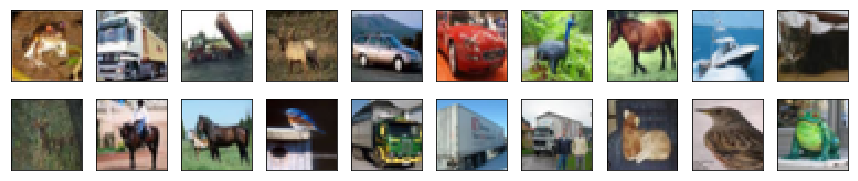

In [9]:
print(len(train_loader.dataset.targets))
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {} each for the three RGB channels.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].reshape(32, 32, 3)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img)
plt.show()

<h3 style="color:rgb(0,120,170)"> Task 4.1 </h3>
Implement the following CNN architecture: <br>
Conv2D layer: input width 3 and output width 10, kernel size 5 (striding=1, padding=0), relu activation <br>
Max_pool2D: 2,2 <br>
Conv2D layer: input width 10 and output width 32, kernel size 5 (striding=1, padding=0), relu activation <br>
Max_pool2D: 2,2 <br>
fully connected layer: 200 output neurons, relu activation <br>
fully connected layer: 82 output neurons, relu activation <br>
fully connected layer: 10 ouput neurons, softmax activation

In [10]:
# CNN architecture (two conv layers followed by three fully connected layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [11]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader, confusion_matrix):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i, t in enumerate(target):
                confusion_matrix[t.cpu().item(), pred[i].cpu().item()] += 1
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [ ]:
# Main
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

confusion_matrix = np.zeros([10,10], int)
for epoch in range(1, args.epochs + 1):
    confusion_matrix = np.zeros([10,10], int)
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader, confusion_matrix)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.288037
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.310546
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.291843
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.278177
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.259901
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.216006
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.032518
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.967399

Test set: Average loss: 1.9166, Accuracy: 2923/10000 (29.23%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.835797
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.915205
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.049452
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.886153
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.544128
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.669383
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.563014
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.661262

Test set: Average loss: 1.5977, Accuracy: 4129/10000 (41.29%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.698597
Train Epoch: 3 [6400/50000 (13%)]	Loss:

In [ ]:
print('{0:10s} {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()